In [1]:
import pandas as pd
from collections import Counter
from pycaret.classification import ClassificationExperiment

- The dataset is from the [American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/overview)  kaggle competition. 
- Goal of the competition is predict credit default based on the customer's monthly profile.
- For each customer, 189 features are provided in the dataset

In [2]:
train_data = pd.read_feather('../data/train_data.ftr')

In [3]:
train_data.shape

(5531451, 191)

In [4]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


The features for each customer are divided into the following 5 categories:
  1. D_* = Delinquency variables
  2. S_* = Spend variables
  3. P_* = Payment variables
  4. B_* = Balance variables
  5. R_* = Risk variables

In [5]:
count_of_feature_type = Counter([
    x.split('_')[0] for x in train_data.columns
    if x not in ['customer_ID', 'target']
])
count_of_feature_type = pd.DataFrame(count_of_feature_type, index=['count']).T
count_of_feature_type

,count
S,22
P,3
D,96
B,40
R,28


0    0.750903
1    0.249097
Name: target, dtype: float64


<AxesSubplot: title={'center': 'Target Distribution'}>

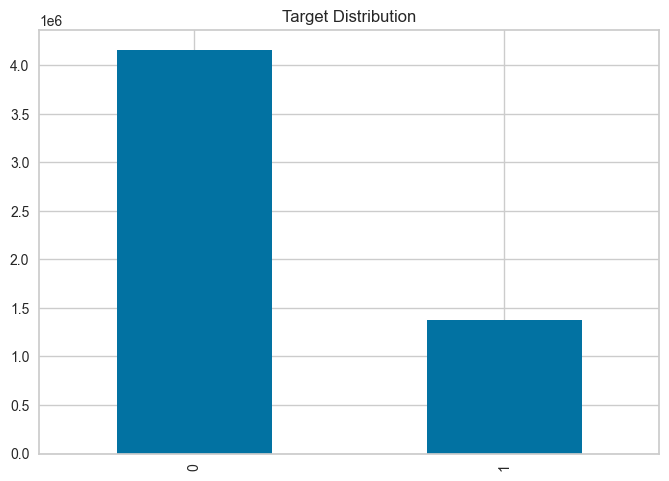

In [6]:
# calculate the percentage of training data that is 1 and 0
print(train_data['target'].value_counts(normalize=True))
train_data['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution')


In [7]:
# get a random sample of 10000 rows
train_rndm_sample = train_data.sample(n=10000, random_state=42)

In [8]:
s = ClassificationExperiment()
s.setup(data=train_rndm_sample, target='target', session_id=123)          

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(10000, 191)"
4,Transformed data shape,"(10000, 224)"
5,Transformed train set shape,"(7000, 224)"
6,Transformed test set shape,"(3000, 224)"
7,Ordinal features,4
8,Numeric features,177
9,Date features,1


In [12]:
best = s.compare_models()

In [13]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [16]:
s.compare_models()

In [22]:
s.compare_models(sort='AUC')

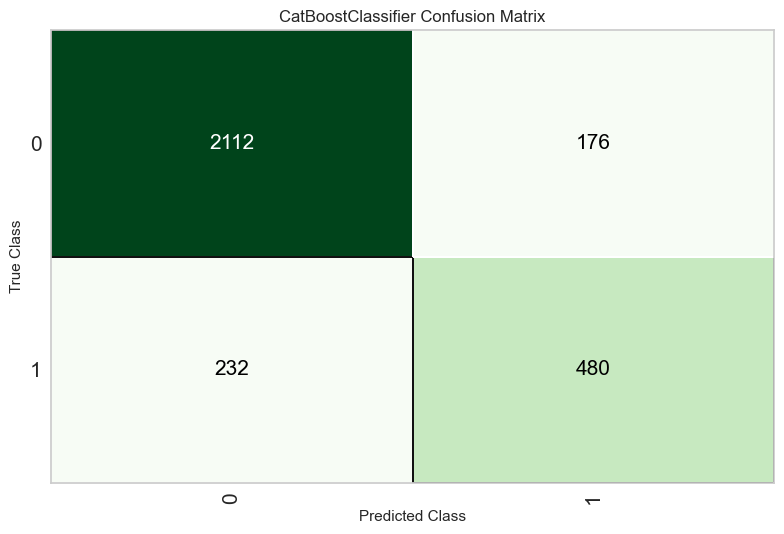

In [19]:
s.plot_model(best, plot = 'confusion_matrix')

In [27]:
s.save_model(best, 'first_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/var/folders/st/9fkv5y5s4dqd7g46g06m83br0000gn/T/joblib),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['S_2'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['P_2', 'D_39', 'B_1', 'B_2', 'R_1',
                                              'S_3', 'D_41'...
                                                               verbose=0))),
                 ('rest_encoding',
                  TransformerWrapper(exclude=None, include=['customer_ID'],
                                     transformer=LeaveOneOutEncoder(cols=['customer_ID'],
   

In [28]:
s.load_model('first_pipeline')

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/var/folders/st/9fkv5y5s4dqd7g46g06m83br0000gn/T/joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['S_2'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['P_2', 'D_39', 'B_1', 'B_2', 'R_1',
                                             'S_3', 'D_41'...
                                                              verbose=0))),
                ('rest_encoding',
                 TransformerWrapper(exclude=None, include=['customer_ID'],
                                    transformer=LeaveOneOutEncoder(cols=['customer_ID'],
                                                                   drop_invariant=False,
                                                                   handle_missing='return_nan',
                                                                   handle_unknown='value',
                                                                   random_state=123,
                                                                   return_df=True,
                                                                   sigma=None,
                                                                   verbose=0))),
                ('trained_model',
                 <catboost.core.CatBoostClassifier object at 0x17e2bfb20>)],
         verbose=False)

In [31]:
s.get_config()

{'USI',
 'X',
 'X_test',
 'X_test_transformed',
 'X_train',
 'X_train_transformed',
 'X_transformed',
 '_available_plots',
 '_ml_usecase',
 'data',
 'dataset',
 'dataset_transformed',
 'exp_id',
 'exp_name_log',
 'fix_imbalance',
 'fold_generator',
 'fold_groups_param',
 'fold_shuffle_param',
 'gpu_n_jobs_param',
 'gpu_param',
 'html_param',
 'idx',
 'is_multiclass',
 'log_plots_param',
 'logging_param',
 'memory',
 'n_jobs_param',
 'pipeline',
 'seed',
 'target_param',
 'test',
 'test_transformed',
 'train',
 'train_transformed',
 'variable_and_property_keys',
 'variables',
 'y',
 'y_test',
 'y_test_transformed',
 'y_train',
 'y_train_transformed',
 'y_transformed'}

In [36]:
s.setup(data = train_rndm_sample, target = 'target', session_id = 123, normalize=True)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(10000, 191)"
4,Transformed data shape,"(10000, 224)"
5,Transformed train set shape,"(7000, 224)"
6,Transformed test set shape,"(3000, 224)"
7,Ordinal features,4
8,Numeric features,177
9,Date features,1


In [40]:
best = s.compare_models()

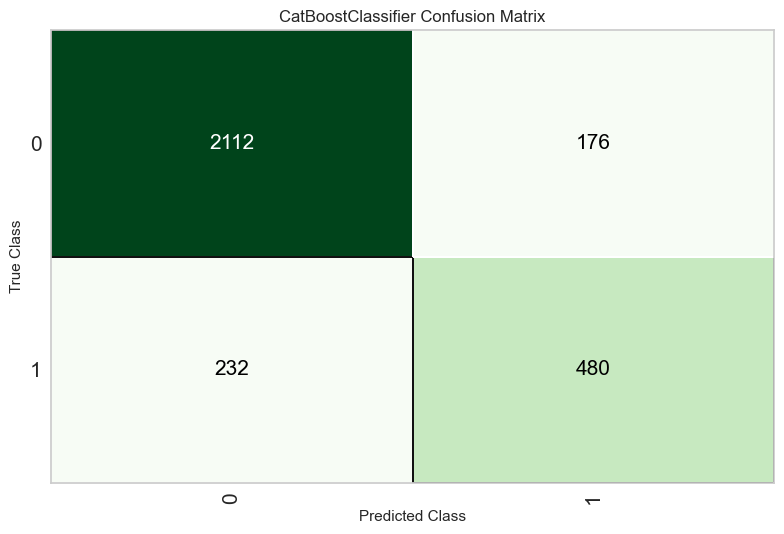

In [41]:
s.plot_model(best, plot = 'confusion_matrix')

In [53]:
pd.DataFrame(s.pull()).sort_values('F1', ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8707,0.9318,0.6982,0.7425,0.7193,0.6355,0.6362,3.295
gbc,Gradient Boosting Classifier,0.8687,0.9291,0.6856,0.7423,0.7124,0.6276,0.6287,2.019
lightgbm,Light Gradient Boosting Machine,0.8673,0.9288,0.6921,0.7340,0.7123,0.6261,0.6267,0.252
lda,Linear Discriminant Analysis,0.8690,0.9233,0.6777,0.7477,0.7104,0.6261,0.6278,0.117
lr,Logistic Regression,0.8647,0.9226,0.6753,0.7344,0.7030,0.6157,0.6171,0.229
ridge,Ridge Classifier,0.8677,0.0000,0.6399,0.7654,0.6964,0.6128,0.6172,0.077
xgboost,Extreme Gradient Boosting,0.8610,0.9233,0.6699,0.7245,0.6957,0.6059,0.6069,1.113
svm,SVM - Linear Kernel,0.8523,0.0000,0.7024,0.6851,0.6924,0.5954,0.5964,0.069
rf,Random Forest Classifier,0.8629,0.9214,0.6483,0.7419,0.6916,0.6040,0.6065,0.089
et,Extra Trees Classifier,0.8626,0.9229,0.6350,0.7485,0.6866,0.5995,0.6031,0.197
